In [1]:
import os, time
import country_converter as coco
import mapclassify

from osgeo import gdal
import pandas as pd 
import geopandas as gpd
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from pathlib import Path 
import pycountry 

import rasterio as rs
from rasterio.plot import show
from rasterio.enums import Resampling
from rasterio.plot import plotting_extent
from rasterio.merge import merge
import rasterio.mask
from rasterio import shutil as rio_shutil
from rasterio.vrt import WarpedVRT

def tPrint(s):
    print("%s\t%s" % (time.strftime("%H:%M:%S"), s))

In [2]:
# To display large numbers in a readable format e.g. without xxe+04
pd.options.display.float_format = '{:20,.2f}'.format

In [3]:
#path = Path('/home/wb411133/data/Projects/FATHOM') #Change Path 
path = Path('/Users/bjafino/Documents/GitHub/PovertyClimateFall2020/FATHOM')

In [4]:
newPoverty = path / 'FloodRiskPop_adm0_02.10.2020.csv'

In [5]:
## Results
Results_FilePath = path / 'Outputs' / 'Results' / 'processed_countries_v02-final.shp'

## Original adm file with all the columns
AdmPath = path / 'GLOBAL' / 'GMGD world admin' / 'newold_geo_code2_povdata_v7.shp'
adm_path_reproj = path / 'GLOBAL'  / 'GMGD world admin' / 'GMGD_reproj' / 'newold_geo_code2_povdata_v6_4326.shp'

In [6]:
# 0) No risk: x = 0
# 1) Limited risk: x <= 0.15
# 2) Moderate risk: 0.15 < x <= 0.5
# 3) High risk: 0.5 < x <= 1.5
# 4) Very high risk: x > 1.5
# 5) Water body: x >= 999

<a id='TOC'></a>
# Table of Contents
- [Preparing Data](#Prep)
 - Read in files
 - Add totals and percentages
 - Merge with admin for analysis
 - Add poverty columns
 - Merge with full admin and export
 - Prep country level results and export
- [Validation](#QA)
 - Comparing flood pop totals to WDI pop

<a id='Prep'></a>
# Preparing data

## Read in files

In [7]:
povertyAll = pd.read_csv(newPoverty)

In [8]:
povertyAll.columns

Index(['ADM0_NAME', 'ISO3', 'sample', 'region', 'region_new', '0-NoRiskPo',
       '1-LowRiskP', '2-Moderate', '3-HighRisk', '4-VeryHigh', 'geo_code2',
       'totalPop', 'fldExpHi', 'fldExpRel', 'poor190_ln', 'poor320_ln',
       'poor550_ln', 'npoor190_l', 'npoor320_l', 'npoor550_l', 'mean_ln',
       'poorExp190', 'poorExp320', 'poorExp550', 'poorPct190', 'poorPct320',
       'poorPct550', 'gdpExp'],
      dtype='object')

In [9]:
povertyAll['npoor190_ln'] = povertyAll['npoor190_l']
povertyAll['npoor320_ln'] = povertyAll['npoor320_l']
povertyAll['npoor550_ln'] = povertyAll['npoor550_l']

In [10]:
poverty = povertyAll[['geo_code2','poor190_ln', 'poor320_ln',
       'poor550_ln', 'npoor190_ln', 'npoor320_ln', 'npoor550_ln',
                 'mean_ln']]

In [11]:
poverty.head(2)

,geo_code2,poor190_ln,poor320_ln,poor550_ln,npoor190_ln,npoor320_ln,npoor550_ln,mean_ln
0,FSM_2013_GADM1_FSM_FSM.4_1,0.16,0.38,0.64,"2,130.47","5,045.59","8,416.59",5.45
1,FSM_2013_GADM1_FSM_FSM.1_1,0.19,0.43,0.73,"9,949.70","22,876.90","38,949.13",4.65


Columns:
- poor190_ln : poverty rate at 1.9 (not in pct) in the area
- noind_ln: number of individuals by area
- totalind_l: total population in the country/data

In [12]:
# Read processed countries shapefile
df = gpd.read_file(Results_FilePath)

In [13]:
for col in ['0-NoRiskPo', '1-LowRiskP', '2-Moderate', '3-HighRisk', '4-VeryHigh', '5-WaterBod']:
    df[col] = df[col].astype(float)

In [14]:
# Distributing 5-WaterBody population to other five categories
df.loc[:,'0-NoRiskPo'] += (df.loc[:,'5-WaterBod'] / 5)
df.loc[:,'1-LowRiskP'] += (df.loc[:,'5-WaterBod'] / 5)
df.loc[:,'2-Moderate'] += (df.loc[:,'5-WaterBod'] / 5)
df.loc[:,'3-HighRisk'] += (df.loc[:,'5-WaterBod'] / 5)
df.loc[:,'4-VeryHigh'] += (df.loc[:,'5-WaterBod'] / 5)

In [15]:
df = df[['ADM0_NAME', 'ISO3', 'sample', 'region',
       '0-NoRiskPo', '1-LowRiskP', '2-Moderate', '3-HighRisk', '4-VeryHigh',
       'geo_code2','geometry']]

In [16]:
df.tail(2)

,ADM0_NAME,ISO3,sample,region,0-NoRiskPo,1-LowRiskP,2-Moderate,3-HighRisk,4-VeryHigh,geo_code2,geometry
2082,Russia,RUS,-1,ECA,"20,871.68","9,319.61","2,404.91",905.77,289.24,RUS_-1_2015_ADM1_2537,"POLYGON ((42.79087863729099 46.38847653824138,..."
2083,Argentina,ARG,Urban sample,LAC,"26,963,206.73","10,648,322.73","4,646,766.73","1,930,900.73","637,515.42",ARG_2018_ADM1_12,(POLYGON ((-64.13139343277857 -54.645515441929...


## Adding totals and percentages

In [17]:
# Adding column with total pop for each row
df.loc[:,'totalPop'] = df.sum(numeric_only=True, axis=1)

In [18]:
lastColIndex = df.columns.get_loc('4-VeryHigh')

In [22]:
# Adding column with total pop exposed to >15cm risk
# Which refers to 2-Moderate Risk and above
df.loc[:,'fldExpHi'] = df.iloc[:,lastColIndex-2:lastColIndex+1].sum(axis=1)

In [23]:
# Pct >15cm of total pop
df.loc[:,'fldExpRel'] = (df.loc[:,'fldExpHi'] / 
                                    df.loc[:,'totalPop']) * 100

## Merge adm

In [24]:
# Merging flood risk results (df) with subset of adm shapefile (adm_subset)
# This def will be used for analysis
# The rest of the adm shapefile will be merged later
df = df.merge(poverty, on = 'geo_code2', how = 'outer')

In [26]:
df.head(2)

,ADM0_NAME,ISO3,sample,region,0-NoRiskPo,1-LowRiskP,2-Moderate,3-HighRisk,4-VeryHigh,geo_code2,...,totalPop,fldExpHi,fldExpRel,poor190_ln,poor320_ln,poor550_ln,npoor190_ln,npoor320_ln,npoor550_ln,mean_ln
0,"Micronesia, Fed. Sts.",FSM,1?Yap,EAP,"10,097.06",455.07,201.92,110.27,128.47,FSM_2013_GADM1_FSM_FSM.4_1,...,"10,992.81",440.67,4.01,0.16,0.38,0.64,"2,130.47","5,045.59","8,416.59",5.45
1,"Micronesia, Fed. Sts.",FSM,2?Chuuk,EAP,"40,962.77","1,052.19",730.31,192.48,7.45,FSM_2013_GADM1_FSM_FSM.1_1,...,"42,945.20",930.24,2.17,0.19,0.43,0.73,"9,949.70","22,876.90","38,949.13",4.65


In [27]:
# reordering cols
df = df[['ADM0_NAME', 'ISO3', 'sample', 'region', '0-NoRiskPo', '1-LowRiskP',
       '2-Moderate', '3-HighRisk', '4-VeryHigh', 'geo_code2',
       'totalPop', 'fldExpHi', 'fldExpRel', 'poor190_ln',
       'poor320_ln', 'poor550_ln', 'npoor190_ln', 'npoor320_ln', 'npoor550_ln',
       'mean_ln', 'geometry']]

## Add in poverty pop exposure >15cm
Data used:
- poor190_ln : poverty rate at 1.9 (not in pct) in the area
- poor320_ln
- poor550_ln

Cols created:
- absolute number of poor exposed to >15cm flood risk
- percent of people exposed to >15cm flood risk and are poor


In [28]:
# Adding column on the absolute number of poor exposed to flood risk above 15cm
# multiply the poor190_ln by the total pop exposed to >15c flood 
df.loc[:,'poorExp190'] = (df.loc[:,'fldExpHi'] * df.loc[:,'poor190_ln'])
df.loc[:,'poorExp320'] = (df.loc[:,'fldExpHi'] * df.loc[:,'poor320_ln'])
df.loc[:,'poorExp550'] = (df.loc[:,'fldExpHi'] * df.loc[:,'poor550_ln'])

In [29]:
# Adding column on the pct of people exposed to >15cm flood and are poor
df.loc[:,'poorPct190'] = (df.loc[:,'poorExp190'] / df.loc[:,'totalPop'])*100
df.loc[:,'poorPct320'] = (df.loc[:,'poorExp320'] / df.loc[:,'totalPop'])*100
df.loc[:,'poorPct550'] = (df.loc[:,'poorExp550'] / df.loc[:,'totalPop'])*100

In [30]:
df.head(2)

,ADM0_NAME,ISO3,sample,region,0-NoRiskPo,1-LowRiskP,2-Moderate,3-HighRisk,4-VeryHigh,geo_code2,...,npoor320_ln,npoor550_ln,mean_ln,geometry,poorExp190,poorExp320,poorExp550,poorPct190,poorPct320,poorPct550
0,"Micronesia, Fed. Sts.",FSM,1?Yap,EAP,"10,097.06",455.07,201.92,110.27,128.47,FSM_2013_GADM1_FSM_FSM.4_1,...,"5,045.59","8,416.59",5.45,"(POLYGON ((143.07833862 6.684165949999993, 143...",71.20,168.61,281.26,0.65,1.53,2.56
1,"Micronesia, Fed. Sts.",FSM,2?Chuuk,EAP,"40,962.77","1,052.19",730.31,192.48,7.45,FSM_2013_GADM1_FSM_FSM.1_1,...,"22,876.90","38,949.13",4.65,"(POLYGON ((153.6361084 5.291110039999997, 153....",173.76,399.52,680.20,0.40,0.93,1.58


## Add in GDP exposure >15cm
-[fldExpHi] * [mean_ln]



In [31]:
# Adding column on GDP exposed to flood risk above 15cm
df.loc[:,'gdpExp'] = (df.loc[:,'fldExpHi'] * df.loc[:,'mean_ln'])

In [32]:
df.head(2)

,ADM0_NAME,ISO3,sample,region,0-NoRiskPo,1-LowRiskP,2-Moderate,3-HighRisk,4-VeryHigh,geo_code2,...,npoor550_ln,mean_ln,geometry,poorExp190,poorExp320,poorExp550,poorPct190,poorPct320,poorPct550,gdpExp
0,"Micronesia, Fed. Sts.",FSM,1?Yap,EAP,"10,097.06",455.07,201.92,110.27,128.47,FSM_2013_GADM1_FSM_FSM.4_1,...,"8,416.59",5.45,"(POLYGON ((143.07833862 6.684165949999993, 143...",71.20,168.61,281.26,0.65,1.53,2.56,"2,401.99"
1,"Micronesia, Fed. Sts.",FSM,2?Chuuk,EAP,"40,962.77","1,052.19",730.31,192.48,7.45,FSM_2013_GADM1_FSM_FSM.1_1,...,"38,949.13",4.65,"(POLYGON ((153.6361084 5.291110039999997, 153....",173.76,399.52,680.20,0.40,0.93,1.58,"4,325.30"


In [33]:
df.columns

Index(['ADM0_NAME', 'ISO3', 'sample', 'region', '0-NoRiskPo', '1-LowRiskP',
       '2-Moderate', '3-HighRisk', '4-VeryHigh', 'geo_code2', 'totalPop',
       'fldExpHi', 'fldExpRel', 'poor190_ln', 'poor320_ln', 'poor550_ln',
       'npoor190_ln', 'npoor320_ln', 'npoor550_ln', 'mean_ln', 'geometry',
       'poorExp190', 'poorExp320', 'poorExp550', 'poorPct190', 'poorPct320',
       'poorPct550', 'gdpExp'],
      dtype='object')

## Export

In [35]:
df.head()

,ADM0_NAME,ISO3,sample,region,0-NoRiskPo,1-LowRiskP,2-Moderate,3-HighRisk,4-VeryHigh,geo_code2,...,npoor550_ln,mean_ln,geometry,poorExp190,poorExp320,poorExp550,poorPct190,poorPct320,poorPct550,gdpExp
0,"Micronesia, Fed. Sts.",FSM,1?Yap,EAP,"10,097.06",455.07,201.92,110.27,128.47,FSM_2013_GADM1_FSM_FSM.4_1,...,"8,416.59",5.45,"(POLYGON ((143.07833862 6.684165949999993, 143...",71.20,168.61,281.26,0.65,1.53,2.56,"2,401.99"
1,"Micronesia, Fed. Sts.",FSM,2?Chuuk,EAP,"40,962.77","1,052.19",730.31,192.48,7.45,FSM_2013_GADM1_FSM_FSM.1_1,...,"38,949.13",4.65,"(POLYGON ((153.6361084 5.291110039999997, 153....",173.76,399.52,680.20,0.40,0.93,1.58,"4,325.30"
2,"Micronesia, Fed. Sts.",FSM,4?Kosrae,EAP,"3,892.94",586.99,422.96,267.70,52.50,FSM_2013_GADM1_FSM_FSM.2_1,...,"3,700.77",6.71,"(POLYGON ((162.96694946 5.281112189999991, 162...",15.57,176.94,435.28,0.30,3.39,8.33,"4,985.88"
3,Australia,AUS,[1]New South Wales,EAP,"5,977,505.53","371,567.37","234,034.41","142,902.78","54,951.34",AUS_2014_ADM1_470,...,"48,468.18",62.08,"(POLYGON ((151.172748 -33.847877, 151.173537 -...","2,451.40","2,909.20","2,909.20",0.04,0.04,0.04,"26,810,262.66"
4,Australia,AUS,[2]Victoria,EAP,"4,540,820.91","398,824.10","220,802.38","122,674.11","39,151.14",AUS_2014_ADM1_476,...,"43,110.04",58.85,"(POLYGON ((146.33117676 -39.14710998000001, 14...","1,947.19","2,935.14","2,935.14",0.04,0.06,0.06,"22,518,356.49"


In [36]:
# Saving to shp to file for analysis
df.to_file(path / 'Analysis' / "new_pov_results_10042021.shp");

## Merge with full adm shp and export

In [39]:
# removed cols already in df
poverty_to_merge = povertyAll[['code', 'baseyear', 'lineupyear', 'survname', 'welfaretype',
       'level', 'geo_code2',
       'poor_ln_b40', 'poor_ln_d1', 'poor_ln_d2', 'poor_ln_d3', 'poor_ln_d4',
       'poor_ln_d5', 'poor_ln_d6', 'poor_ln_d7', 'poor_ln_d8', 'poor_ln_d9',
       'poor_ln_d10', 'nohh_ln', 'totalhh_ln',
       'sh_hh_ln', 'sh_pop_ln', 'd_ln1', 'd_ln2', 'd_ln3', 'd_ln4', 'd_ln5',
       'd_ln6', 'd_ln7', 'd_ln8', 'd_ln9', 'd_ln10', 'sh_d_ln1', 'sh_d_ln2',
       'sh_d_ln3', 'sh_d_ln4', 'sh_d_ln5', 'sh_d_ln6', 'sh_d_ln7', 'sh_d_ln8',
       'sh_d_ln9', 'sh_d_ln10', 'total_d_ln1', 'total_d_ln2', 'total_d_ln3',
       'total_d_ln4', 'total_d_ln5', 'total_d_ln6', 'total_d_ln7',
       'total_d_ln8', 'total_d_ln9', 'total_d_ln10', 'median_ln', 'mean_ln',
       'giniln', 'theilln', 'b40_ln', 't60_ln', 'totalb40_ln', 'totalt60_ln',
       'sh_b40_ln', 'sh_t60_ln']]

In [78]:
df_full = df.merge(poverty_to_merge, on = 'geo_code2', how = 'outer')

In [79]:
# Reordering cols
df_full = df_full[['ADM0_NAME', 'ISO3', 'sample', 'region', '0-NoRiskPo', '1-LowRiskP',
       '2-Moderate', '3-HighRisk', '4-VeryHigh', 'geo_code2',
       'totalPop', 'fldExpHi', 'fldExpRel', 'poorExp190', 'poorExp320',
       'poorExp550', 'poorPct190', 'poorPct320', 'poorPct550', 'poor190_ln',
       'poor320_ln', 'poor550_ln', 'npoor190_ln', 'npoor320_ln', 'npoor550_ln',
       'noind_ln', 'totalind_ln', 'code', 'baseyear',
       'lineupyear', 'survname', 'welfaretype', 'level',
       'poor_ln_b40', 'poor_ln_d1', 'poor_ln_d2', 'poor_ln_d3', 'poor_ln_d4',
       'poor_ln_d5', 'poor_ln_d6', 'poor_ln_d7', 'poor_ln_d8', 'poor_ln_d9',
       'poor_ln_d10', 'nohh_ln', 'totalhh_ln', 'sh_hh_ln', 'sh_pop_ln',
       'd_ln1', 'd_ln2', 'd_ln3', 'd_ln4', 'd_ln5', 'd_ln6', 'd_ln7', 'd_ln8',
       'd_ln9', 'd_ln10', 'sh_d_ln1', 'sh_d_ln2', 'sh_d_ln3', 'sh_d_ln4',
       'sh_d_ln5', 'sh_d_ln6', 'sh_d_ln7', 'sh_d_ln8', 'sh_d_ln9', 'sh_d_ln10',
       'total_d_ln1', 'total_d_ln2', 'total_d_ln3', 'total_d_ln4',
       'total_d_ln5', 'total_d_ln6', 'total_d_ln7', 'total_d_ln8',
       'total_d_ln9', 'total_d_ln10', 'median_ln', 'mean_ln', 'giniln',
       'theilln', 'b40_ln', 't60_ln', 'totalb40_ln', 'totalt60_ln',
       'sh_b40_ln', 'sh_t60_ln','geometry']]

In [82]:
# Saving to shp to file for analysis
df_full.to_file(path / 'Analysis' / "new_pov_results_merged.shp");

In [98]:
# Saving as a shapefile truncates the col names 
# Converting from a geodf to a normal df to allow export
#df_nongeo = pd.DataFrame(df_full)

In [99]:
# this created a huge incorrectly formatted file (300mb)
#df_nongeo.to_csv(path / 'Analysis' / "results_merged_adm.csv") 

In [100]:
# del df_ nongeo
del df_full

## Prepping country level data 
- dissolving to adm0 level
- have to re-add the columns with percentages 

In [40]:
countries = df[['ADM0_NAME', 'ISO3', '0-NoRiskPo', '1-LowRiskP',
       '2-Moderate', '3-HighRisk', '4-VeryHigh', 'geo_code2', 'totalPop',
       'fldExpHi',  
       'npoor190_ln', 'npoor320_ln', 'npoor550_ln', 'mean_ln', 'geometry',
       'poorExp190', 'poorExp320', 'poorExp550', 'gdpExp']]
# not including pcts because it doesn't aggregate well

In [41]:
# This can take a long time 
countries = countries.dissolve(by='ADM0_NAME', aggfunc='sum')

In [42]:
# Adding Pct >15cm of total pop
countries.loc[:,'fldExpRel'] = (countries.loc[:,'fldExpHi'] / 
                                    countries.loc[:,'totalPop']) * 100

In [68]:
countries.head(3)

,geometry,0-NoRiskPo,1-LowRiskP,2-Moderate,3-HighRisk,4-VeryHigh,totalPop,fldExpHi,npoor190_ln,npoor320_ln,npoor550_ln,mean_ln,poorExp190,poorExp320,poorExp550,gdpExp,fldExpRel,poorPct190,poorPct320,poorPct550
ADM0_NAME,,,,,,,,,,,,,,,,,,,,
Afghanistan,"POLYGON ((71.02527542392174 34.55837377942642,...","20,729,301.66","5,065,939.48","2,616,966.83","1,236,505.85","647,603.87","30,296,317.67","4,501,076.54",0.00,0.00,0.00,0.00,0.00,0.00,0.00,0.00,14.86,0.00,0.00,0.00
Albania,"(POLYGON ((19.2769680001731 40.51499099983483,...","1,594,778.57","431,977.53","327,700.54","253,289.58","189,002.46","2,796,748.67","769,992.57","31,360.33","203,188.68","894,455.25",99.67,"7,976.02","50,434.86","240,188.81","6,917,044.40",27.53,0.29,1.80,8.59
Algeria,(POLYGON ((-1.913019299700863 35.0882247997347...,"33,759,208.60","5,450,192.60","2,918,637.10","1,448,055.10","508,003.76","44,084,097.14","4,874,695.95","136,284.66","949,588.00","8,847,020.00",9.17,"15,731.62","109,612.90","1,021,229.77","44,695,234.81",11.06,0.04,0.25,2.32


In [44]:
# Adding column on the pct of people exposed to >15cm flood and are poor
countries.loc[:,'poorPct190'] = (countries.loc[:,'poorExp190'] / countries.loc[:,'totalPop'])*100
countries.loc[:,'poorPct320'] = (countries.loc[:,'poorExp320'] / countries.loc[:,'totalPop'])*100
countries.loc[:,'poorPct550'] = (countries.loc[:,'poorExp550'] / countries.loc[:,'totalPop'])*100

In [45]:
countries['ADM0'] = countries.index

In [46]:
# Saving file 
countries.to_file(path / 'Analysis' / "aggCountries_10042021.shp");

<a id='QA'></a>
# Validation

[Back to TOC](#TOC)

## Comparing total pops against WDI pop data

In [123]:
WDI_pop = pd.read_csv(path / 'API_SP.POP.TOTL_DS2_en_csv_v2_1976634.csv', sep=';', encoding = "ISO-8859-1")
WDI_pop = WDI_pop[['Country Name','Country Code','2015','2016','2017','2018']]
WDI_pop = WDI_pop.set_index('Country Name');

In [124]:
countries.index = countries.ADM0

In [125]:
# join with countries df
WDI_pop = WDI_pop.merge(countries[['totalPop']], left_index=True, right_index=True)

In [130]:
# Add column comparing 2018 WDI pop data with World Pop data
WDI_pop['pop_check'] = (WDI_pop['totalPop'] / WDI_pop['2018'])
WDI_pop.dropna(subset=['pop_check'], inplace=True)

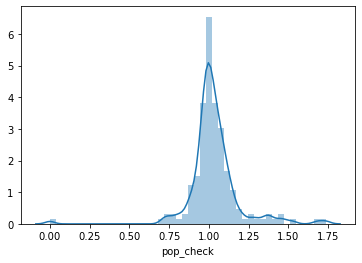

In [131]:
sns.distplot(WDI_pop.pop_check)

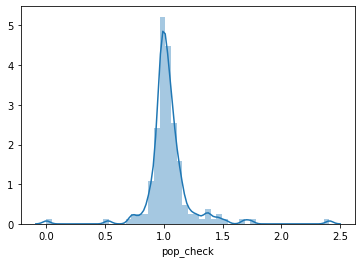

In [117]:
#OLD DATA - DO NOT DELETE
sns.distplot(WDI_pop.pop_check)

In [132]:
print(WDI_pop[(WDI_pop.pop_check < 0.9) | (WDI_pop.pop_check > 1.1)].shape[0], 
      'countries with a pop difference greater than 10% ')

50 countries with a pop difference greater than 10% 


In [133]:
print(WDI_pop[(WDI_pop.pop_check < 0.8) | (WDI_pop.pop_check > 1.2)].shape[0], 
      'countries with a pop difference greater than 20% ')

21 countries with a pop difference greater than 20% 


In [134]:
print(WDI_pop[(WDI_pop.pop_check >= 0.8) | (WDI_pop.pop_check <= 1.2)].shape[0], 
      'countries with a pop difference less than 20% ')

174 countries with a pop difference less than 20% 


In [135]:
WDI_pop[(WDI_pop.pop_check < 0.8) | (WDI_pop.pop_check > 1.2)]

,Country Code,2015,2016,2017,2018,totalPop,pop_check
Andorra,AND,"78,011.00","77,297.00","77,001.00","77,006.00","113,078.73",1.47
Cambodia,KHM,"15,521,436.00","15,766,293.00","16,009,414.00","16,249,798.00","19,522,729.68",1.20
Colombia,COL,"47,520,667.00","48,175,048.00","48,909,844.00","49,661,056.00","63,257,306.40",1.27
Djibouti,DJI,"913,993.00","929,112.00","944,097.00","958,920.00","1,152,545.63",1.20
Fiji,FJI,"868,627.00","872,399.00","877,459.00","883,483.00","699,249.93",0.79
Gabon,GAB,"1,947,686.00","2,007,873.00","2,064,823.00","2,119,275.00","2,971,743.36",1.40
Haiti,HTI,"10,695,542.00","10,839,970.00","10,982,366.00","11,123,176.00","14,625,015.38",1.31
Jordan,JOR,"9,266,575.00","9,551,467.00","9,779,173.00","9,956,011.00","7,138,388.04",0.72
Latvia,LVA,"1,977,527.00","1,959,537.00","1,942,248.00","1,927,174.00","2,456,387.45",1.27
Lebanon,LBN,"6,532,678.00","6,711,121.00","6,811,873.00","6,848,925.00","9,336,980.35",1.36
